In [305]:
import simpy
import numpy as np
from scipy.stats import expon, t
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import random
import seaborn as sns
import pickle 

In [123]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_all()
sns.set_style("darkgrid", {"grid.color": "white", "grid.linestyle": "--"})

# Define simulation class, visualization and helper functions 

In [124]:
# Question 4: hyperexponential distribution for service time
def hyperexponential_rvs(mus: np.array, probs: np.array, n: int, random_state: int):
    """
        Generates n samples from a hyperexponential distribution with getting single sample x ~ exp(mus[i]) with probability probs[i].
    """

    choices = np.random.default_rng(random_state).choice(len(mus), size=n, p=probs)
    samples = np.zeros(n)

    for i, mu in enumerate(mus):
        mask = (choices == i)
        samples[mask] = expon.rvs(scale=1/mu, size=np.sum(mask), random_state=random_state)
    
    return samples

In [125]:
class MMN:
    def __init__(
        self, 
        rho: float, 
        mu: float, 
        num_servers_arr: np.array, 
        T: int, 
        random_state: int,
        SJF: bool = False,
        deterministic_service_time: float = None,
        hyperexp_service_time_params: dict = None
    ):
        """
            rho: the load of the system.
            mu: the capacity of each of the N servers.
            num_servers_arr: an array of different number of servers to run simulation for, 
                i.e. [1,2] denotes simulation is run with the same samples when there are 1 servers and 2 servers.
            T: the time horizon to run the simulation for.
            random_state: random_state used for seeding.
            SJF: If true, shortest job is first scheduled, otherwise, FIFO is used.
            deterministic_service_time: If not None, it is used as the deterministic service time.
            hyperexp_service_time_params: If not None, it is a dictionary containing:
                - 'mus': an array of rate parameters for the exponential distributions.
                - 'probs': an array of probabilities corresponding to each exponential distribution.
        """
    
        self.rho = rho
        self.mu = mu

        # Set the arrival rate self.lamb of the number of jobs into the system.
        if deterministic_service_time:
            self.lamb = rho * (num_servers_arr * deterministic_service_time)
        elif hyperexp_service_time_params:
            if 'mus' not in hyperexp_service_time_params or 'probs' not in hyperexp_service_time_params:
                raise ValueError("hyperexponential_service_time_params must contain 'mus' and 'probs' keys")
            
            self.mus = np.array(hyperexp_service_time_params['mus'])
            self.probs = np.array(hyperexp_service_time_params['probs'])
            self.lamb = rho * (num_servers_arr * (self.mus * self.probs).sum())
        else:
            self.lamb = rho * (num_servers_arr * mu)
    
        self.num_servers_arr = num_servers_arr
        self.T = T
        self.batch_sample_size = np.ceil(self.lamb*self.T*5).astype(int)
        self.num_diff_N = len(num_servers_arr)
        self.SJF = SJF
        self.deterministic_service_time = deterministic_service_time
        self.hyperexp_service_time_params = hyperexp_service_time_params

        # Reproducibility params
        self.random_state_lamb = random_state
        self.random_state_mu = random_state + 1
        self.random_state_jump = 10^4

        # SimPy environment and resources
        self.env_FIFO = simpy.Environment()
        self.env_SJF = simpy.Environment()
        self.servers_diff_N_FIFO = [simpy.Resource(self.env_FIFO, capacity=N) for N in num_servers_arr]
        self.servers_diff_N_SJF = [simpy.PriorityResource(self.env_SJF, capacity=N) for N in num_servers_arr]

        # Statistics
        self.waiting_times_FIFO = [[] for _ in range(self.num_diff_N)]
        self.system_times_FIFO = [[] for _ in range(self.num_diff_N)]
        self.waiting_times_SJF = [[] for _ in range(self.num_diff_N)]
        self.system_times_SJF = [[] for _ in range(self.num_diff_N)]

        # Get initial samples
        self.job_arrival_times_initial = [0]*self.num_diff_N
        self.service_durations_initial= [0]*self.num_diff_N
        for i in range(self.num_diff_N):
            self.job_arrival_times_initial[i], self.service_durations_initial[i] = self.__get_events(i, self.random_state_lamb, self.random_state_mu)

    def __get_events(self, Ns_idx, random_state_lamb, random_state_mu):
        lamb = self.lamb[Ns_idx]
        batch_sample_size = self.batch_sample_size[Ns_idx]
        job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)
        service_durations = None
                
        # Since service duration is random, we check for whether hyperexponential dist is used for service duration.
        if self.hyperexp_service_time_params:
            service_durations = hyperexponential_rvs(self.mus, self.probs, batch_sample_size, random_state_mu)
        elif self.deterministic_service_time:
            pass
        else:
            service_durations = expon.rvs(scale=1/self.mu, size=batch_sample_size, random_state=random_state_mu)
        
        return job_arrival_times, service_durations

    def __job_arrival_FIFO(self, Ns_idx):
        """Generate job arrivals (FIFO)."""
        job_arrival_times = self.job_arrival_times_initial[Ns_idx]
        service_durations = self.service_durations_initial[Ns_idx]
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env_FIFO.timeout(job_arrival_time)
                    arrival_time = self.env_FIFO.now
                    self.env_FIFO.process(self.__job_process_FIFO(service_duration, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
        else:
            while True:
                for job_arrival_time in job_arrival_times:
                    yield self.env_FIFO.timeout(job_arrival_time)
                    arrival_time = self.env_FIFO.now
                    self.env_FIFO.process(self.__job_process_FIFO(self.deterministic_service_time, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)

    def __job_arrival_SJF(self, Ns_idx):
        """Generate job arrivals (SJF)."""
        job_arrival_times = self.job_arrival_times_initial[Ns_idx]
        service_durations = self.service_durations_initial[Ns_idx]
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env_SJF.timeout(job_arrival_time)
                    arrival_time = self.env_SJF.now
                    self.env_SJF.process(self.__job_process_SJF(service_duration, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
        else:
            while True:
                for job_arrival_time in job_arrival_times:
                    yield self.env_SJF.timeout(job_arrival_time)
                    arrival_time = self.env_SJF.now
                    self.env_SJF.process(self.__job_process_SJF(self.deterministic_service_time, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
            
    def __job_process_FIFO(self, service_duration, Ns_idx, arrival_time):
        """Process a single job (FIFO)."""
    
        with self.servers_diff_N_FIFO[Ns_idx].request() as request:
            yield request

            self.waiting_times_FIFO[Ns_idx].append(self.env_FIFO.now - arrival_time)

            yield self.env_FIFO.timeout(service_duration)
            
            self.system_times_FIFO[Ns_idx].append(self.env_FIFO.now - arrival_time)
    
    def __job_process_SJF(self, service_duration, Ns_idx, arrival_time):
        """Process a single job (SJF)."""
        with self.servers_diff_N_SJF[Ns_idx].request(priority=service_duration) as request:
            yield request

            self.waiting_times_SJF[Ns_idx].append(self.env_SJF.now - arrival_time)

            yield self.env_SJF.timeout(service_duration)
            
            self.system_times_SJF[Ns_idx].append(self.env_SJF.now - arrival_time)
        
    def run_simulation(self):
        """Run the simulation."""
        # Run the simulation for different N at once consequently for both FIFO and SJF services.
        for Ns_idx in range(self.num_diff_N):
            self.env_FIFO.process(self.__job_arrival_FIFO(Ns_idx))
            self.env_FIFO.run(until=self.T*(Ns_idx+1))
        
        result_FIFO = {
            'avg_waiting_times': [np.mean(wt) for wt in self.waiting_times_FIFO],
            'avg_system_times': [np.mean(st) for st in self.system_times_FIFO],
            'waiting_times': self.waiting_times_FIFO,
            'system_times': self.system_times_FIFO
        }
            
        for Ns_idx in range(self.num_diff_N):
            self.env_SJF.process(self.__job_arrival_SJF(Ns_idx))
            self.env_SJF.run(until=self.T*(Ns_idx+1))

        result_SJF = {
            'avg_waiting_times': [np.mean(wt) for wt in self.waiting_times_SJF],
            'avg_system_times': [np.mean(st) for st in self.system_times_SJF],
            'waiting_times': self.waiting_times_SJF,
            'system_times': self.system_times_SJF
        }

        return result_FIFO, result_SJF

# Test 
# num_servers_arr = np.array([1,2,4])
# rho=0.9
# mu=1
# T=100
# num_runs=10
# deterministic_service_time=None
# hyperexp_service_time_params=None

# queue = MMN(
#     rho=rho,
#     mu=mu,
#     num_servers_arr=np.array(num_servers_arr),
#     T=T,
#     random_state=1,
#     deterministic_service_time=deterministic_service_time,
#     hyperexp_service_time_params=hyperexp_service_time_params
# )

# result_FIFO, result_SJF = queue.run_simulation()

# print(result_FIFO['avg_waiting_times'])
# print(result_SJF['avg_waiting_times'])

In [322]:
def convert_to_float32(results):
    results_32 = {}
    for key in results:
        if key.startswith('conf_') or key.startswith('avg_'):
            results_32[key] = results[key].astype(float)
        else:
            results_32[key] = results[key]
    
    return results_32

def run_multiple_simulations(
        num_runs: np.array, 
        rhos: np.array, 
        mu: float, 
        num_servers_arr: np.array, 
        T: int, 
        random_state_offset=0,
        save_file=None, 
        load_file=None,
        deterministic_service_time=None,
        hyperexp_service_time_params=None
    ):
    """Run multiple simulations and average the results."""

    seed_all()

    num_diff_N = len(num_servers_arr)
    smallest_rho = np.min(rhos)
    largest_rho = np.max(rhos)
    num_rhos = len(rhos)
    num_diff_run = len(num_runs)
    max_num_run = np.max(num_runs)
    smallest_num_run = np.min(num_runs)
    
    file_prefix = f'rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{smallest_num_run}_to_{max_num_run}_with_num_{num_diff_run}_'

    results_FIFO = {
        'avg_waiting_times': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'avg_system_times': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_waiting_time_upper': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_waiting_time_lower': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_system_time_upper': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_system_time_lower': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'waiting_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)],
        'system_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)]
    }

    results_SJF = {
        'avg_waiting_times': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'avg_system_times': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_waiting_time_upper': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_waiting_time_lower': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_system_time_upper': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'conf_system_time_lower': np.zeros((num_rhos, num_diff_run, num_diff_N), dtype=np.float16),
        'waiting_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)],
        'system_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)]
    }

    if load_file:
        if deterministic_service_time:
            with open(f'data/{file_prefix}SJF_D.pkl', 'rb') as f:
                results_SJF = pickle.load(f)
            with open(f'data/{file_prefix}FIFO_D.pkl', 'rb') as f:
                results_FIFO = pickle.load(f)
        elif hyperexp_service_time_params: 
            with open(f'data/{file_prefix}SJF_H.pkl', 'rb') as f:
                results_SJF = pickle.load(f)
            with open(f'data/{file_prefix}FIFO_H.pkl', 'rb') as f:
                results_FIFO = pickle.load(f)
        else: 
            with open(f'data/{file_prefix}SJF_M.pkl', 'rb') as f:
                results_SJF = pickle.load(f)
            with open(f'data/{file_prefix}FIFO_M.pkl', 'rb') as f:
                results_FIFO = pickle.load(f)
        
        results_FIFO = convert_to_float32(results_FIFO)
        results_SJF = convert_to_float32(results_SJF)

        return results_FIFO, results_SJF

    rho_MC_idxs = [(rho_idx, i) for i in range(max_num_run) for rho_idx in range(num_rhos)]

    MMNs = [
        MMN(
            rho=rhos[rho_MC_idx[0]],
            mu=mu,
            num_servers_arr=np.array(num_servers_arr),
            T=T,
            random_state=random_state_offset + rho_MC_idx[1],
            deterministic_service_time=deterministic_service_time,
            hyperexp_service_time_params=hyperexp_service_time_params
        )
        for rho_MC_idx in rho_MC_idxs
    ]

    def run_simulation(idxs):
        rho_idx, mc_idx = idxs
        return MMNs[rho_idx * max_num_run + mc_idx].run_simulation()

    results_diff_rhos_runs = None

    # We use random_state to seed parallel programming
    with ThreadPoolExecutor() as ex:
        results_diff_rhos_runs = list(ex.map(run_simulation, rho_MC_idxs))
    
    def process_results(results, sim_res, rho_idx, num_mc, num_servers_arr, num_mc_idx):
        """Helper function to process results for FIFO or SJF."""
        for key in sim_res:
            if key.startswith('avg_'):
                results[key][rho_idx, num_mc_idx] += sim_res[key]
            elif key.startswith('conf_'):
                pass
            else:
                for N_Idx in range(len(num_servers_arr)):
                    results[key][rho_idx][N_Idx].extend(sim_res[key][N_Idx])

        for key in results:
            if key.startswith('avg_'):
                results[key][rho_idx] /= num_mc
        
        conf_margin_waiting_time = [
            np.std(waiting_times, ddof=1) * t.ppf(0.975, num_mc - 1) / np.sqrt(num_mc)
            for waiting_times in results['waiting_times'][rho_idx]
        ]
        conf_margin_system_time = [
            np.std(system_times, ddof=1) * t.ppf(0.975, num_mc - 1) / np.sqrt(num_mc)
            for system_times in results['system_times'][rho_idx]
        ]

        # Store confidence intervals
        results['conf_waiting_time_upper'][rho_idx, num_mc_idx] = [
            results['avg_waiting_times'][rho_idx, num_mc_idx][i] + conf_margin
            for i, conf_margin in enumerate(conf_margin_waiting_time)
        ]
        results['conf_waiting_time_lower'][rho_idx, num_mc_idx] = [
            results['avg_waiting_times'][rho_idx, num_mc_idx][i] - conf_margin
            for i, conf_margin in enumerate(conf_margin_waiting_time)
        ]

        results['conf_system_time_upper'][rho_idx, num_mc_idx] = [
            results['avg_system_times'][rho_idx, num_mc_idx][i] + conf_margin
            for i, conf_margin in enumerate(conf_margin_system_time)
        ]
        results['conf_system_time_lower'][rho_idx, num_mc_idx] = [
            results['avg_system_times'][rho_idx, num_mc_idx][i] - conf_margin
            for i, conf_margin in enumerate(conf_margin_system_time)
        ]

        return results

    for rho_idx in range(num_rhos):
        for num_mc_idx, num_mc in enumerate(num_runs):
            results_diff_runs = results_diff_rhos_runs[rho_idx*max_num_run:rho_idx*max_num_run+num_mc+1]
            for sim_res_FIFO, sim_res_SJF in results_diff_runs:
                results_FIFO = process_results(results_FIFO, sim_res_FIFO, rho_idx, num_mc, num_servers_arr, num_mc_idx)
                results_SJF = process_results(results_SJF, sim_res_SJF, rho_idx, num_mc, num_servers_arr,num_mc_idx)

    
    if save_file:
        if deterministic_service_time:
            with open(f'data/{file_prefix}FIFO_D.pkl', 'wb') as f:
                pickle.dump(results_FIFO, f)
            with open(f'data/{file_prefix}SJF_D.pkl', 'wb') as f:
                pickle.dump(results_SJF, f)
        elif hyperexp_service_time_params: 
            with open(f'data/{file_prefix}FIFO_H.pkl', 'wb') as f:
                pickle.dump(results_FIFO, f)
            with open(f'data/{file_prefix}SJF_H.pkl', 'wb') as f:
                pickle.dump(results_SJF, f)
        else: 
            with open(f'data/{file_prefix}FIFO_M.pkl', 'wb') as f:
                pickle.dump(results_FIFO, f)
            with open(f'data/{file_prefix}SJF_M.pkl', 'wb') as f:
                pickle.dump(results_SJF, f)
            
    results_FIFO = convert_to_float32(results_FIFO)
    results_SJF = convert_to_float32(results_SJF)

    return results_FIFO, results_SJF

In [ ]:
def sns_lineplot(rhos, results, axs, num_servers_arr, Ns_Idx, service_type='FIFO', color = 'blue', num_run_idx=-1): 

    conf_waiting_time_lower = np.maximum(results['conf_waiting_time_lower'][:, num_run_idx, Ns_Idx], 0)
    conf_system_time_lower = np.maximum(results['conf_system_time_lower'][:, num_run_idx, Ns_Idx], 0)

    # Plot average waiting time with confidence intervals
    sns.lineplot(x=rhos, y=results['avg_waiting_times'][:, num_run_idx, Ns_Idx], ax=axs[0], label=f'{num_servers_arr[Ns_Idx]}', marker='o', color=color)
    axs[0].fill_between(
        rhos,
        conf_waiting_time_lower,
        results['conf_waiting_time_upper'][:, num_run_idx, Ns_Idx],
        color=color, 
        alpha=0.2
    )

    axs[0].plot(rhos, conf_waiting_time_lower, color=color, linestyle='--', linewidth=1, alpha=0.5)
    axs[0].plot(rhos, results['conf_waiting_time_upper'][:, num_run_idx, Ns_Idx], color=color, linestyle='--', linewidth=1, alpha=0.5)

    # Plot average system time with confidence intervals
    sns.lineplot(x=rhos, y=results['avg_system_times'][:, num_run_idx, Ns_Idx], ax=axs[1], label=f'{num_servers_arr[Ns_Idx]}', marker='o', color=color)
    axs[1].fill_between(
        rhos, 
        conf_system_time_lower, 
        results['conf_system_time_upper'][:, num_run_idx, Ns_Idx], 
        color=color,
        alpha=0.2
    )

    axs[1].plot(rhos, conf_system_time_lower, color=color, linestyle='--', linewidth=1, alpha=0.5)
    axs[1].plot(rhos, results['conf_system_time_upper'][:, num_run_idx, Ns_Idx], color=color, linestyle='--', linewidth=1, alpha=0.5)

    axs[0].set_xlabel(r'$\rho$', fontsize=14)
    axs[0].set_ylabel(f'Mean Waiting Time', fontsize=14) 
    axs[1].set_xlabel(r'$\rho$', fontsize=14)
    axs[1].set_ylabel(f'Mean System Time', fontsize=14)

    # Set legends for each subplot
    axs[0].legend(title='Number of Servers', fontsize=12)
    axs[1].legend(title='Number of Servers', fontsize=12)

    axs[0].set_title(f'{service_type}', fontsize=16)

def plot_rho_against_stat(
    results_FIFO,
    results_SJF, 
    num_servers_arr, 
    rhos,
    num_run_idx=-1,
    file_name=None
):
    num_diff_N = len(num_servers_arr)    
    _, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=300, sharey=True, sharex=True)
    colors = ['orange', 'green', 'blue']

    for j in range(num_diff_N):
        sns_lineplot(rhos, results_FIFO, axs[:, 0], num_servers_arr, j, color=colors[j], num_run_idx=num_run_idx)
        sns_lineplot(rhos, results_SJF, axs[:, 1], num_servers_arr, j, 'SJF', color=colors[j], num_run_idx=num_run_idx)

    plt.tight_layout()

    if file_name:
        plt.savefig(f'figures/{file_name}.png')  
    
    plt.show()

In [395]:
def Welch_test(results, rhos, num_runs, num_diff_servers): 
    pvalues = np.zeros((num_diff_servers-1, len(num_runs), len(rhos)))
    for num_mc_idx, num_mc in enumerate(num_runs): 
        for rho_idx, _ in enumerate(rhos):
            means = results['avg_waiting_times'][rho_idx, num_mc_idx]
            stds = (results['conf_waiting_time_upper'][rho_idx, num_mc_idx, 0] - means) / t.ppf(0.975, num_mc - 1) * np.sqrt(num_mc)
            for i in range(num_diff_servers-1):
                var_sum = stds[0]**2 + stds[i+1]**2
                t_stat = (means[0]-means[i+1]) / np.sqrt(var_sum / num_mc)
                dof = (num_mc-1)*(var_sum**2) / (stds[0]**2 + stds[i+1]**2)
                pvalues[i, num_mc_idx, rho_idx] = 1 - t.cdf(np.abs(t_stat), dof)

    return pvalues


def plot_pvalues_heatmap(X, Y, pvalues, num_servers_array, file_name=None):
    fig, axs = plt.subplots(1, len(pvalues), figsize=(11, 5), dpi=300, sharex=True, sharey=True)    
    axs_flat = axs.flatten()
    titles = [fr'$\mathbb{{E}}[W(1)]$ and $\mathbb{{E}}[W({n})]$' for n in num_servers_array[1:]]
    
    cmap = plt.get_cmap('plasma_r') 
    cmap.set_under('black') 
    
    for ax, pvalue, title in zip(axs, pvalues, titles):
        heatmap = ax.contourf(X, Y, pvalue, cmap=cmap,  vmin=0.05, levels=20)  # Set vmin and vmax
        ax.set_ylabel('Number of Simulations', fontsize=14)
        ax.set_title(title, fontsize=16)
        ax.grid()
    
    # Create a colorbar with the specified limits
    cbar = fig.colorbar(heatmap, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('p-value', labelpad=10)  # Add padding to the colorbar label
    
    axs_flat[0].set_xlabel(r'$\rho$', fontsize=14)
    plt.tight_layout() 
    plt.subplots_adjust(wspace=0.07, hspace=0.07, right=0.86)

    if file_name:
        plt.savefig(f'figures/{file_name}.png')  

    plt.show()  


In [417]:
np.linspace(0.02,1,50)


array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

# Question 2 and 3

In [ ]:
num_servers_arr = np.array([1,2,4])
# rhos=np.linspace(0.01,1,3)
# mu=1
rhos=[0.01,0.45,0.9]
mu=2
T=1000
num_runs=np.linspace(2,200,9).astype(int)

results_FIFO, results_SJF = run_multiple_simulations(num_runs=num_runs, rhos=rhos, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, save_file=True)

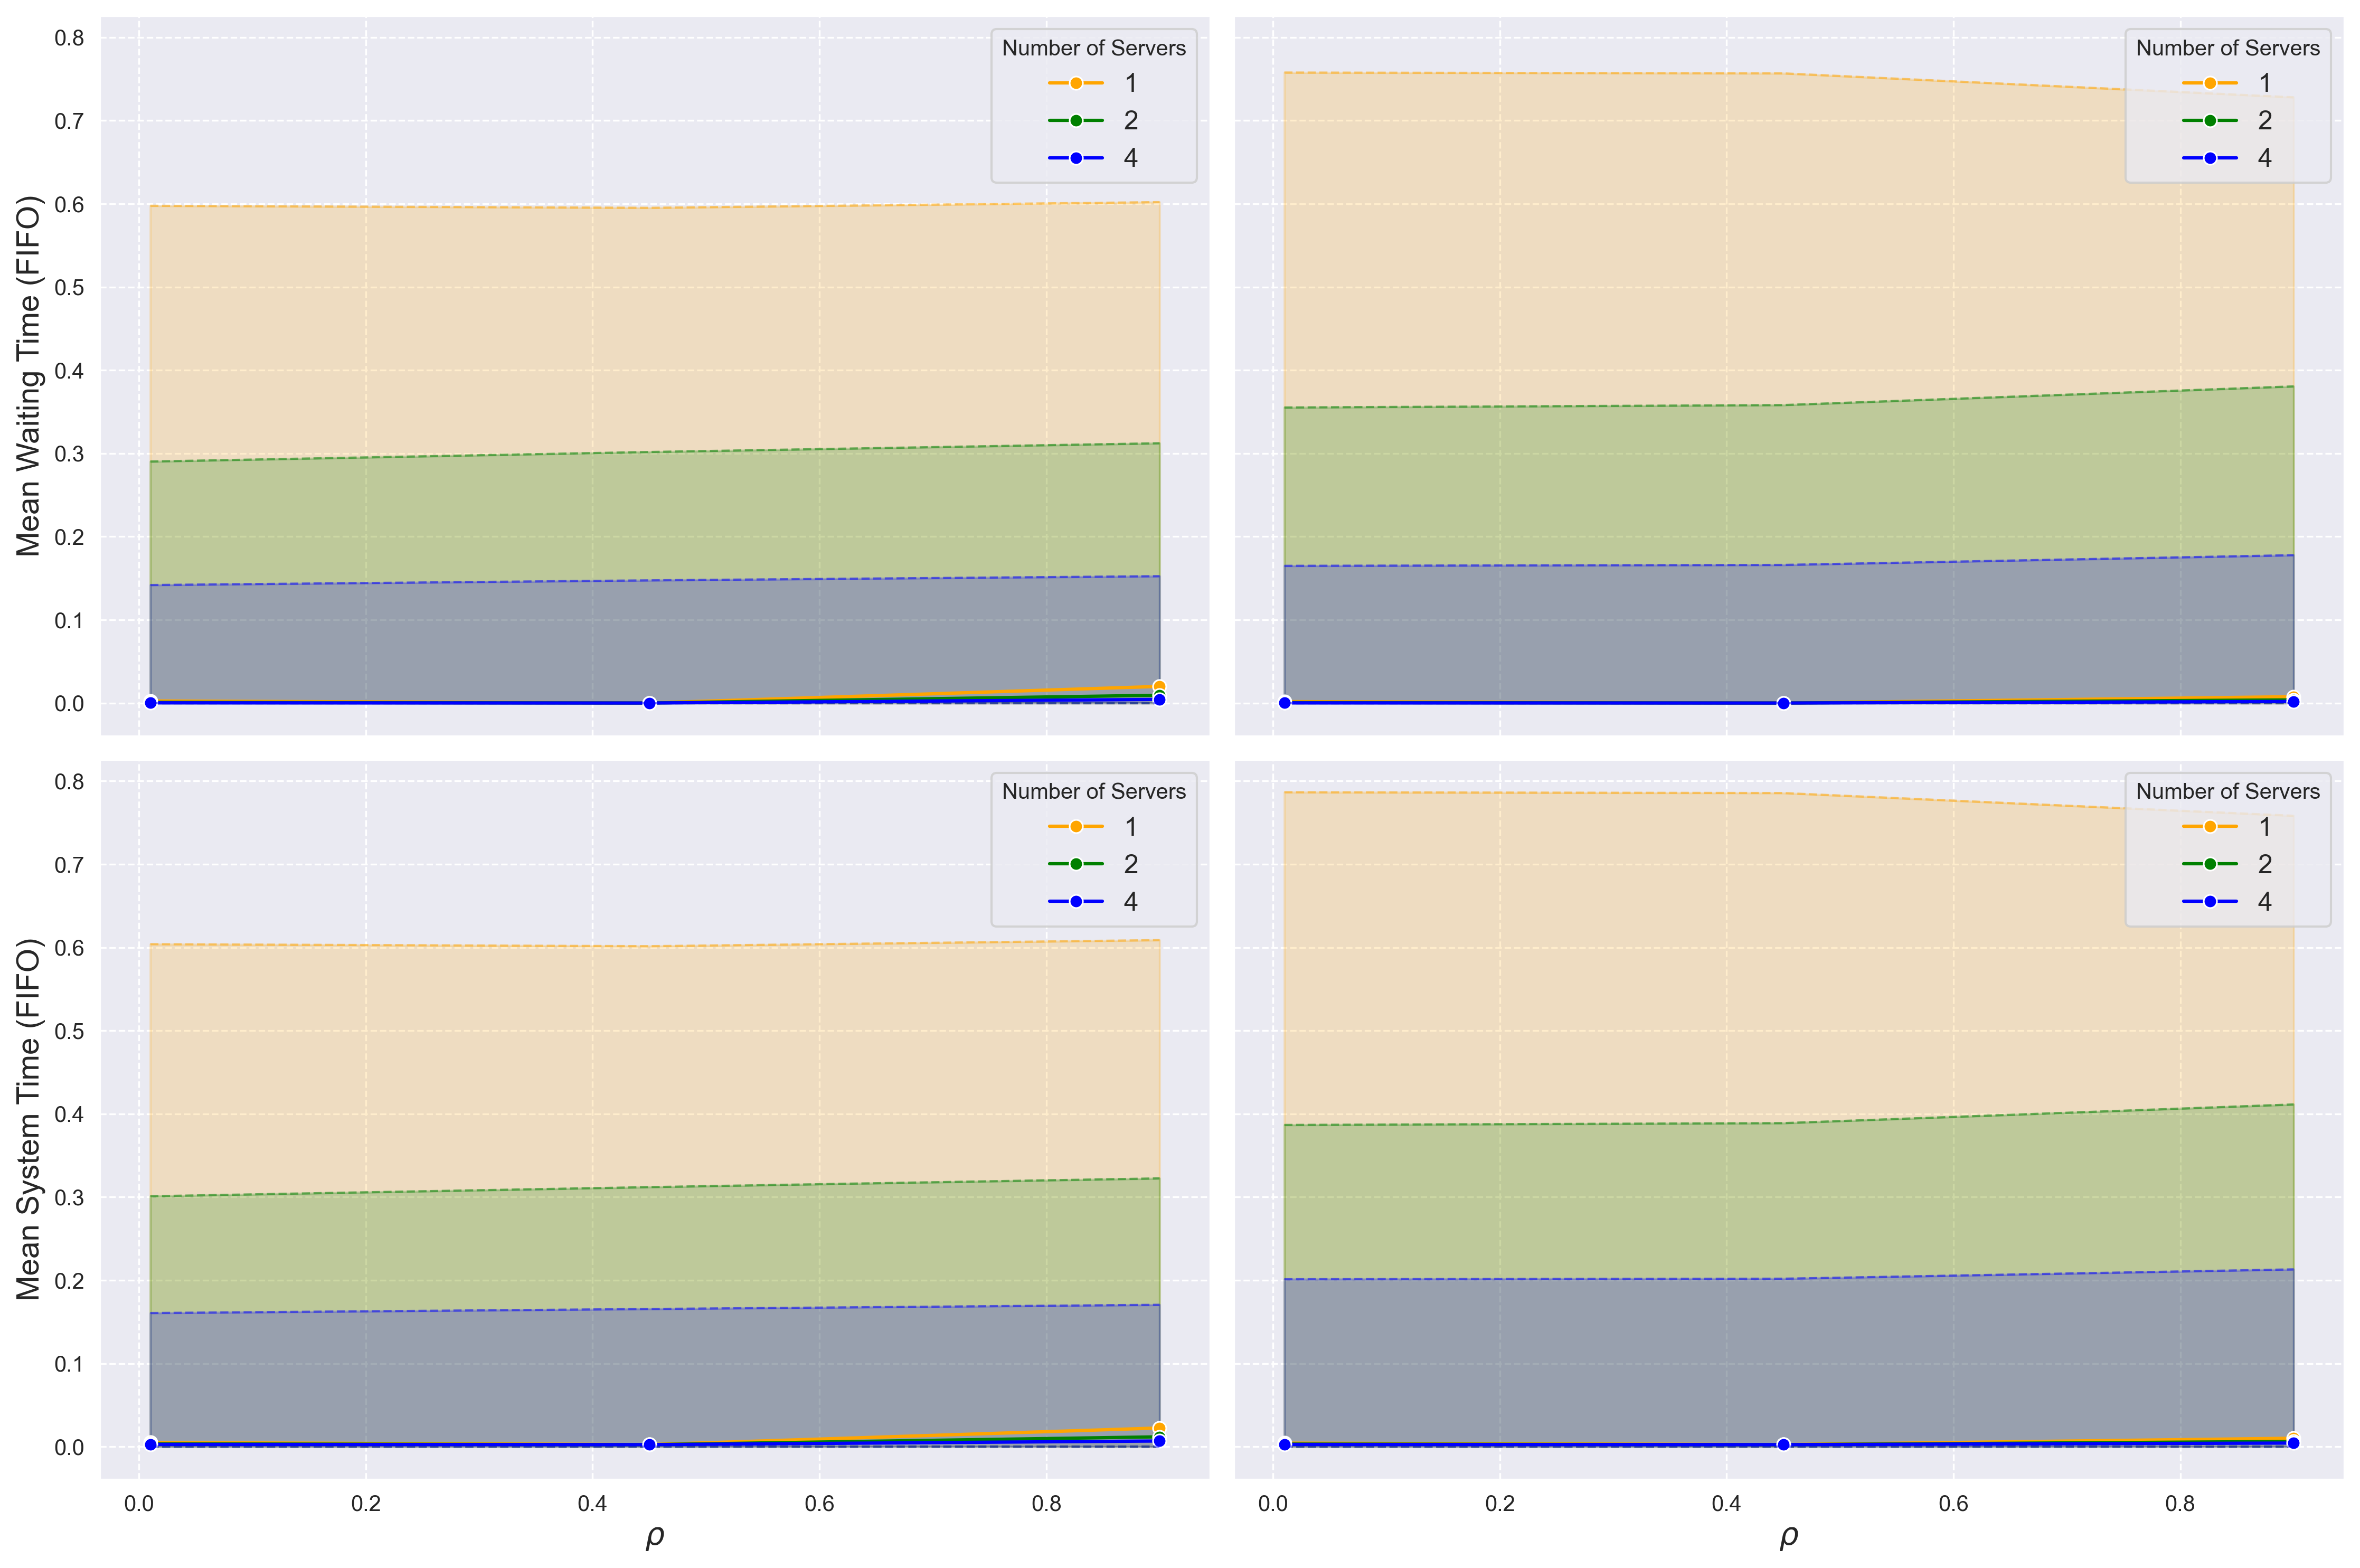

In [332]:
plot_rho_against_stat(results_FIFO, results_SJF, num_servers_arr, rhos, num_run_idx=-1)

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\152148540.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


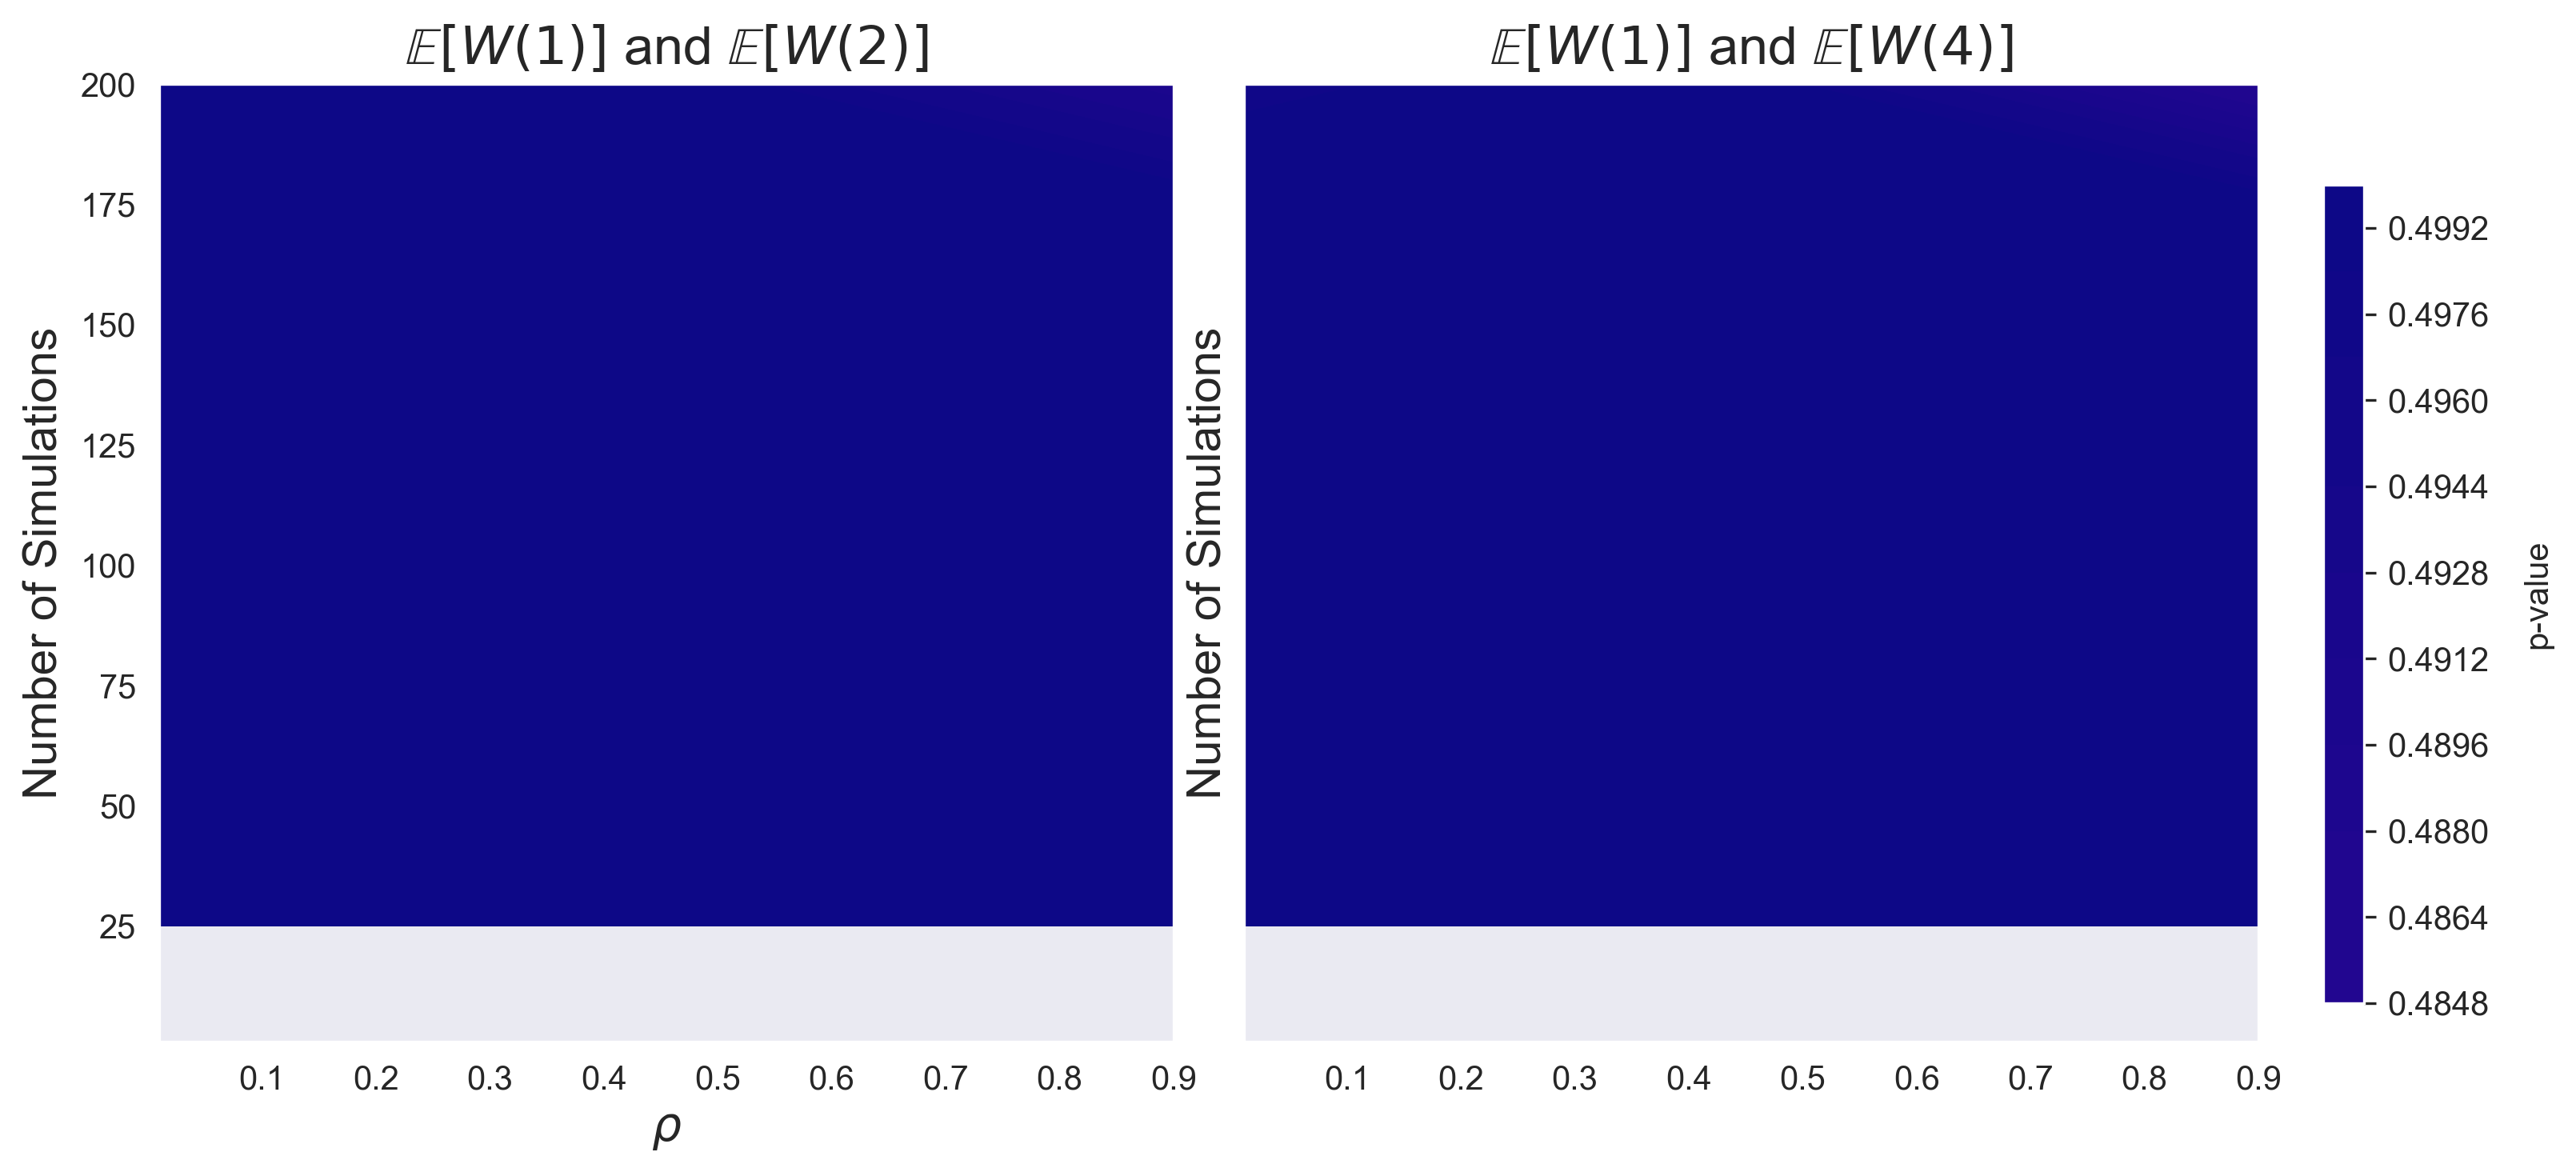

In [394]:
X,Y = np.meshgrid(rhos, num_runs)
pvalues_FIFO = Welch_test(results_FIFO, rhos, num_runs, len(num_servers_arr))
plot_pvalues_heatmap(X, Y, pvalues_FIFO, num_servers_arr, file_name='pvalues_FIFO_MMN')

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\1375568111.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


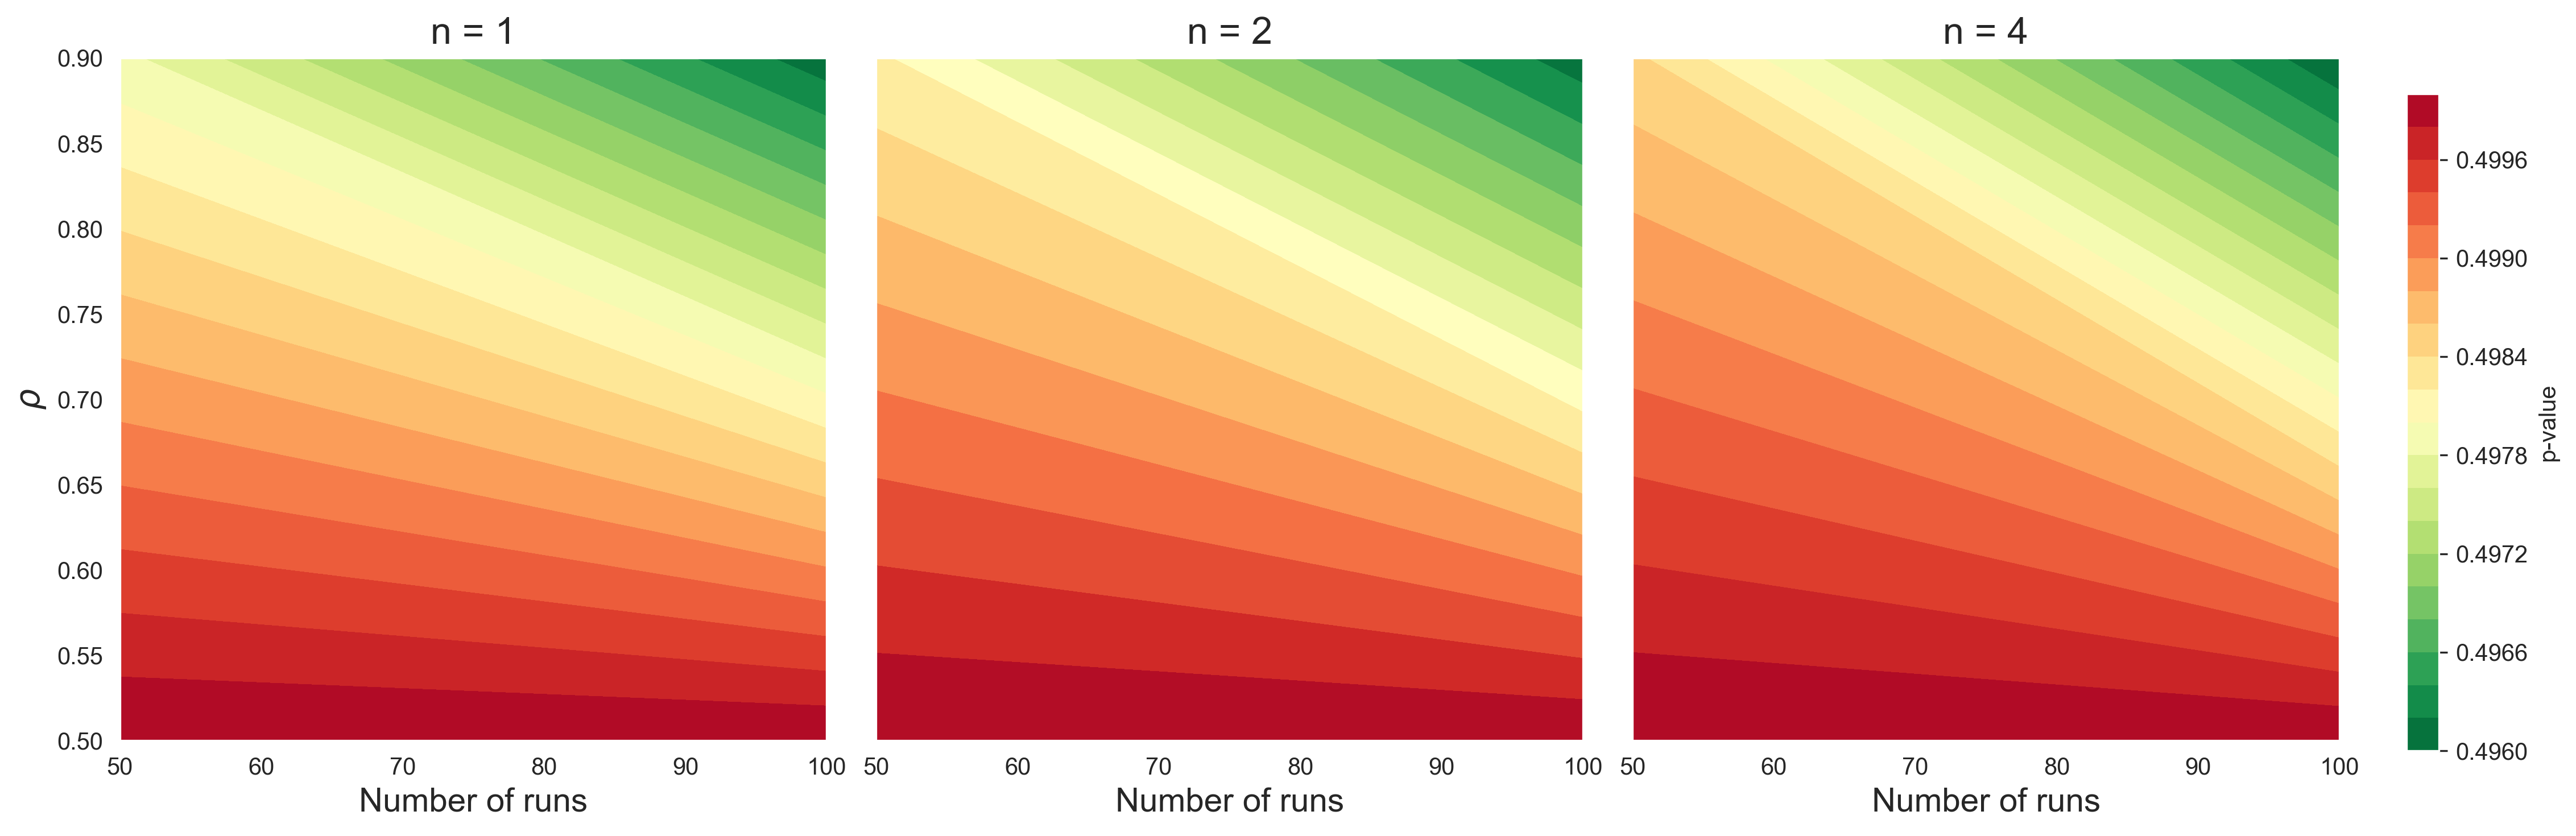

In [ ]:
p_value_SJF = Welch_test(results_SJF, rhos, num_runs)
plot_pvalues_heatmap(X, Y, p_value_SJF, file_name='pvalues_SJF_MMN')

# Question 4

## MDN

In [164]:
num_servers_arr = np.array([1,2,4])
rhos=[0.5, 0.9]
mu=None
T=500
num_runs=np.array([50, 100])
deterministic_service_time=1

results_MDN_FIFO, results_MDN_SJF = run_multiple_simulations(num_runs=num_runs, rhos=rhos, mu=mu, num_servers_arr=num_servers_arr, T=T, deterministic_service_time=deterministic_service_time)

results_MDN_FIFO = convert_to_float32(results_MDN_FIFO)
results_MDN_SJF = convert_to_float32(results_MDN_SJF)

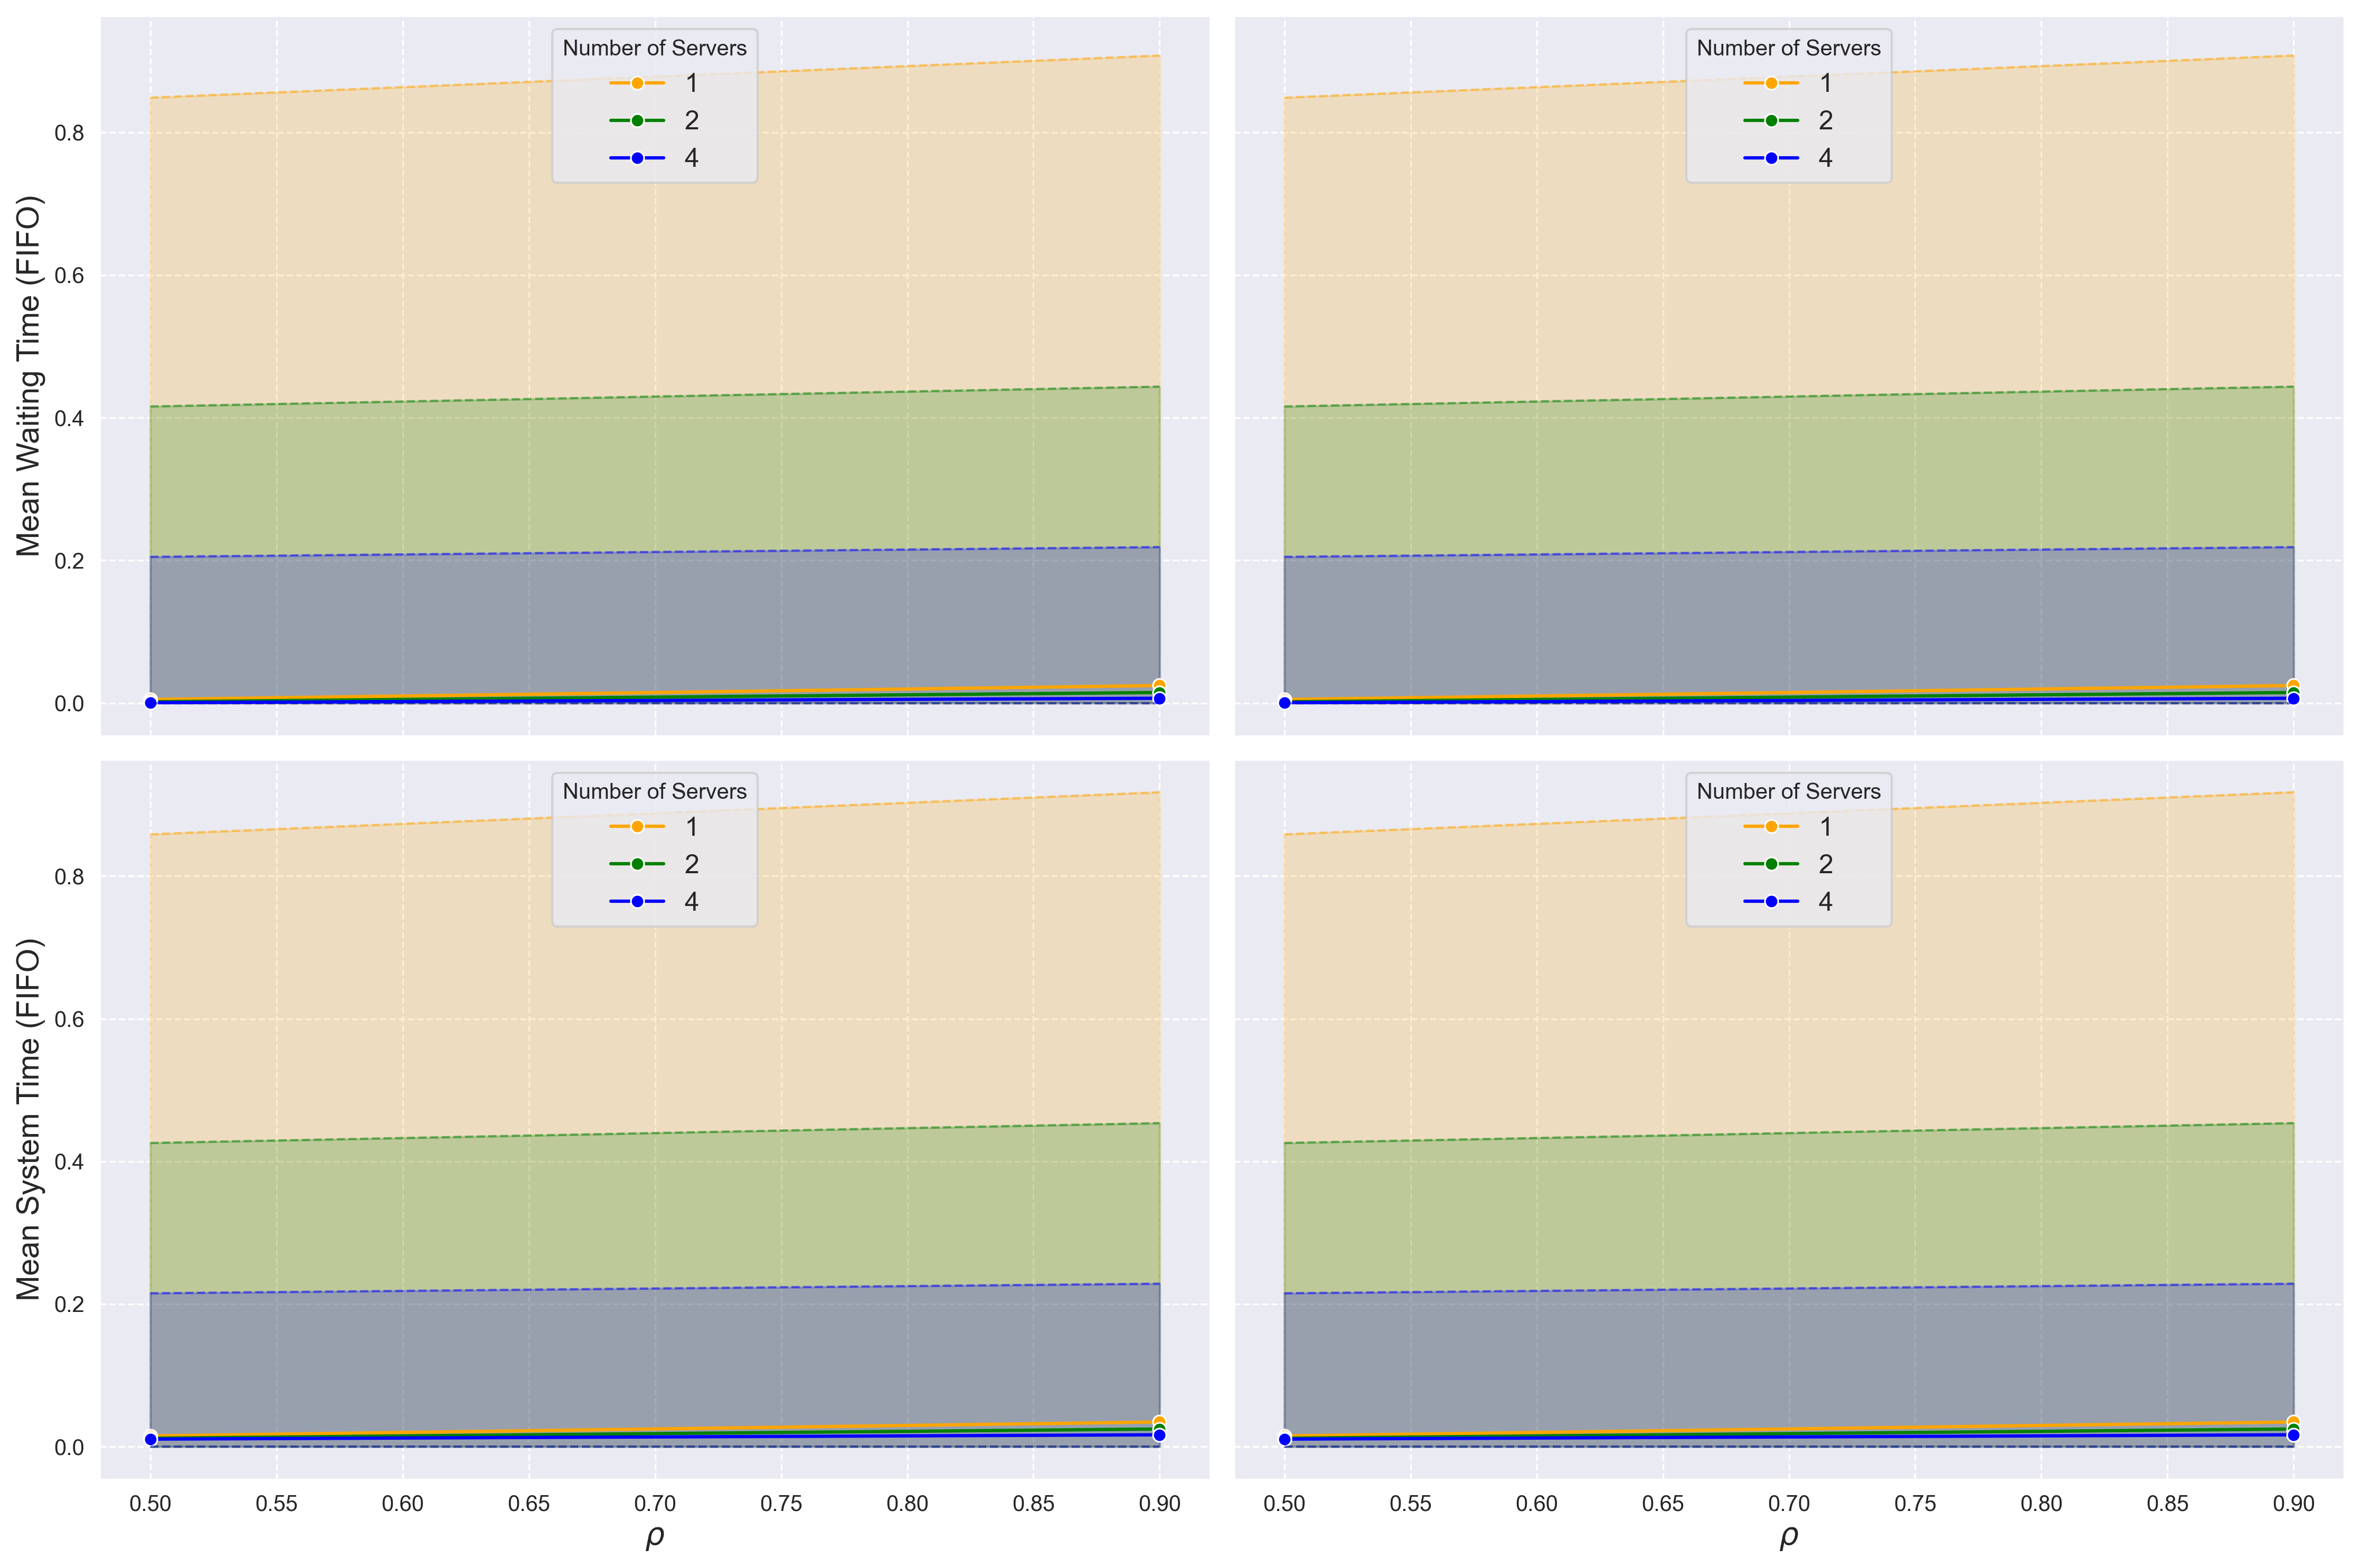

In [165]:
plot_rho_against_stat(results_MDN_FIFO, results_MDN_SJF, num_servers_arr, rhos, num_run_idx=-1)

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\1375568111.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


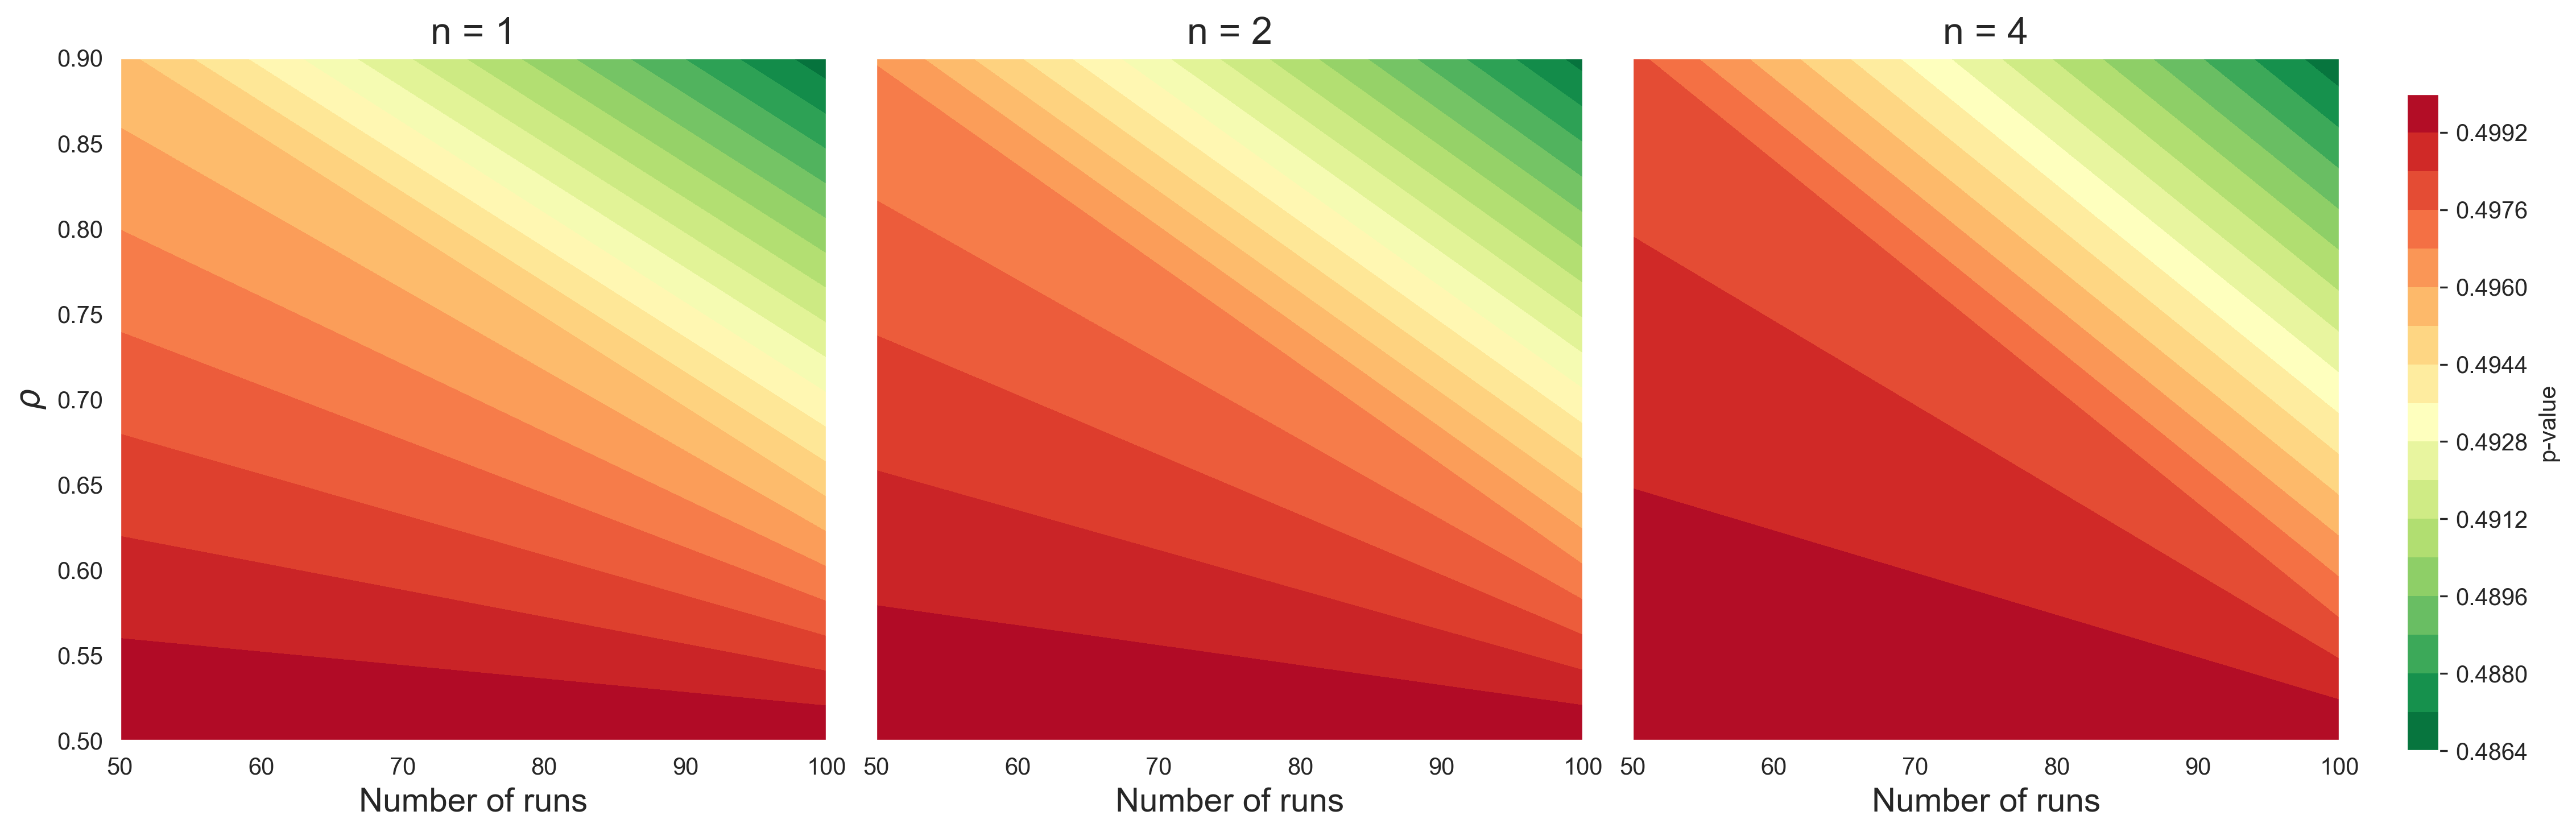

In [266]:
p_value_MDN_FIFO = Welch_test(results_MDN_FIFO, rhos, num_runs, variable='waiting_times')
plot_rho_numruns_against_pvalue(X, Y, p_value_MDN_FIFO, file_name=None)

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\1375568111.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


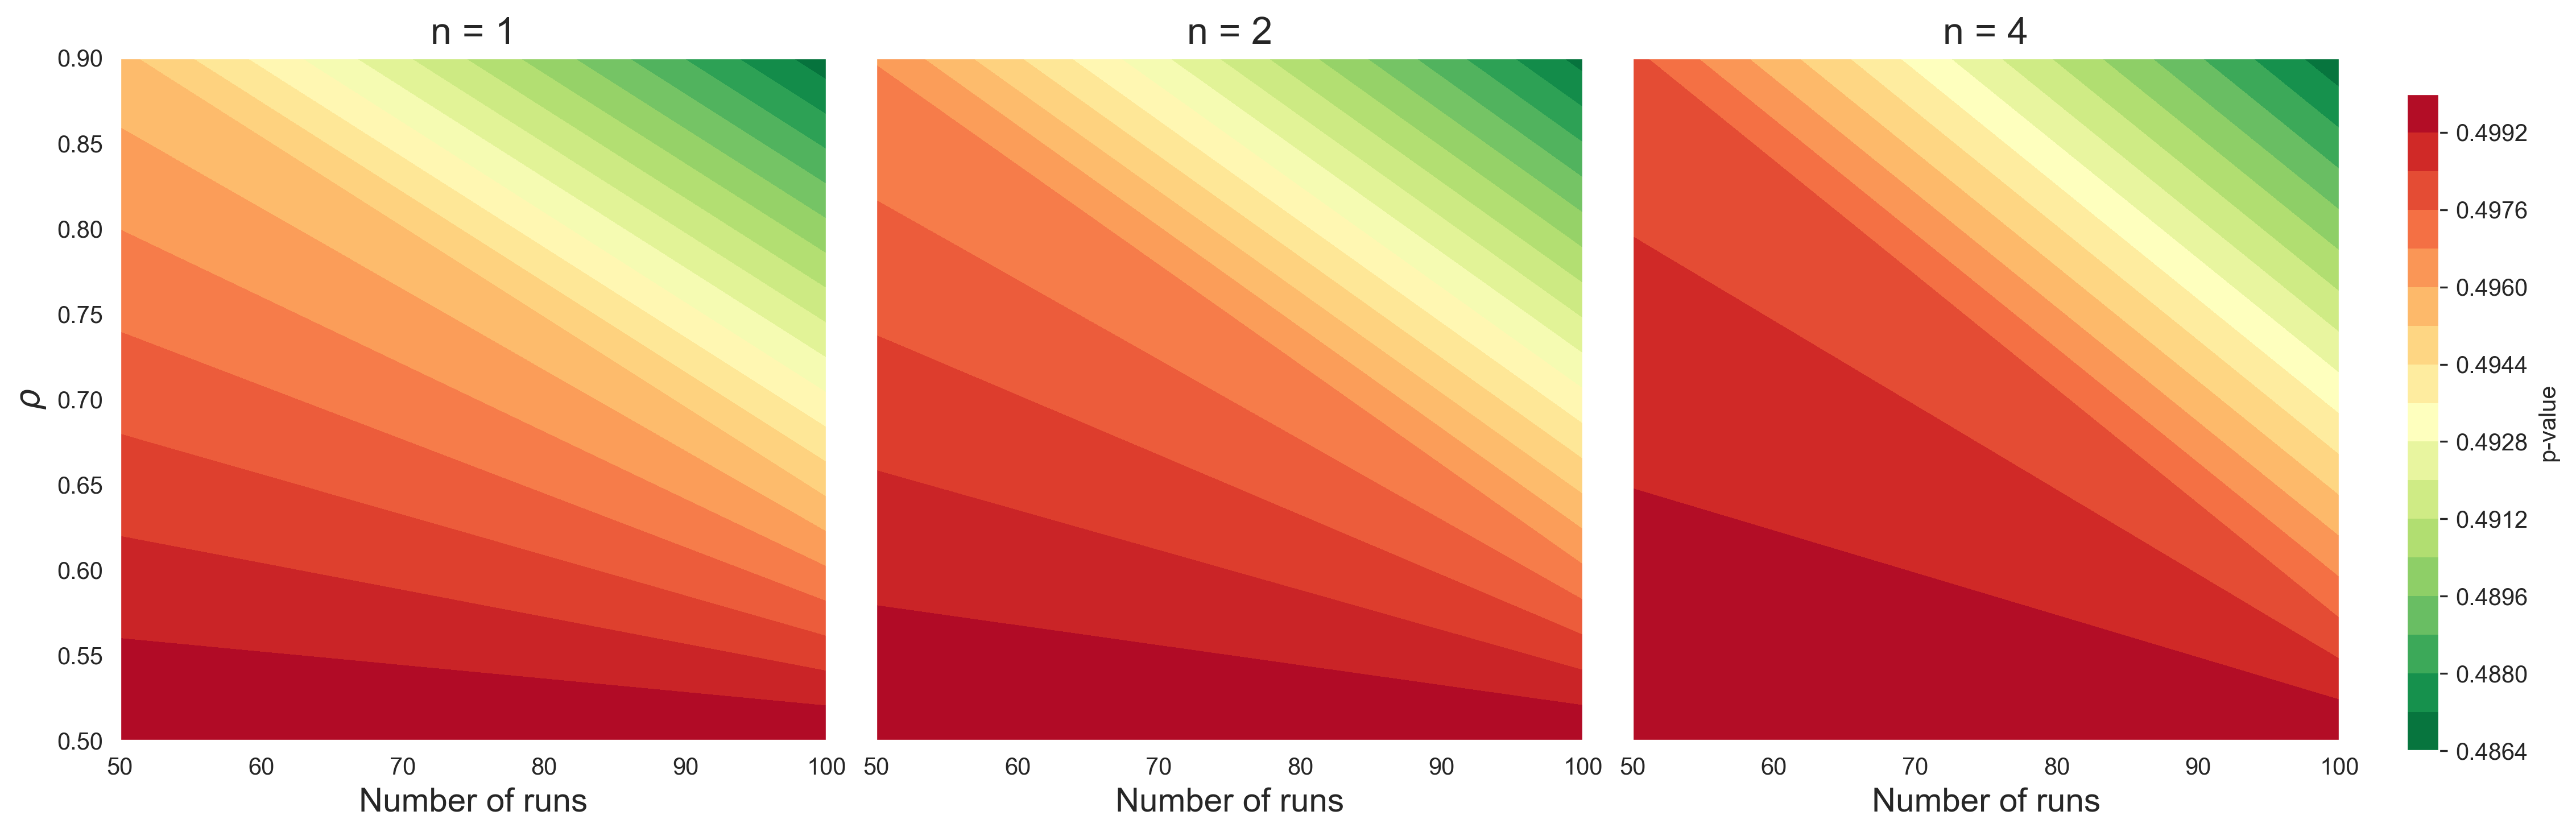

In [267]:
p_value_MDN_SJF = Welch_test(results_MDN_SJF, rhos, num_runs, variable='waiting_times')
plot_rho_numruns_against_pvalue(X, Y, p_value_MDN_SJF, file_name=None)

## Hyperexponential service time

Lambda here is calculated as self.lamb = rho * (num_servers_arr * (mus * probs).sum())

In [166]:
num_servers_arr = [1,2,4]
rhos=[0.5, 0.9]
mu=None
T=500
num_runs=np.array([50, 100])
# Need to be changed!!!
hyperexp_service_time_params={
    'mus': np.array([0.25, 1.5]),
    'probs': np.array([0.4, 0.6])
}


results_hyperexp_FIFO, results_hyperexp_SJF = run_multiple_simulations(num_runs=num_runs, rhos=rhos, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, hyperexp_service_time_params=hyperexp_service_time_params)

results_hyperexp_FIFO = convert_to_float32(results_hyperexp_FIFO)
results_hyperexp_SJF = convert_to_float32(results_hyperexp_SJF)

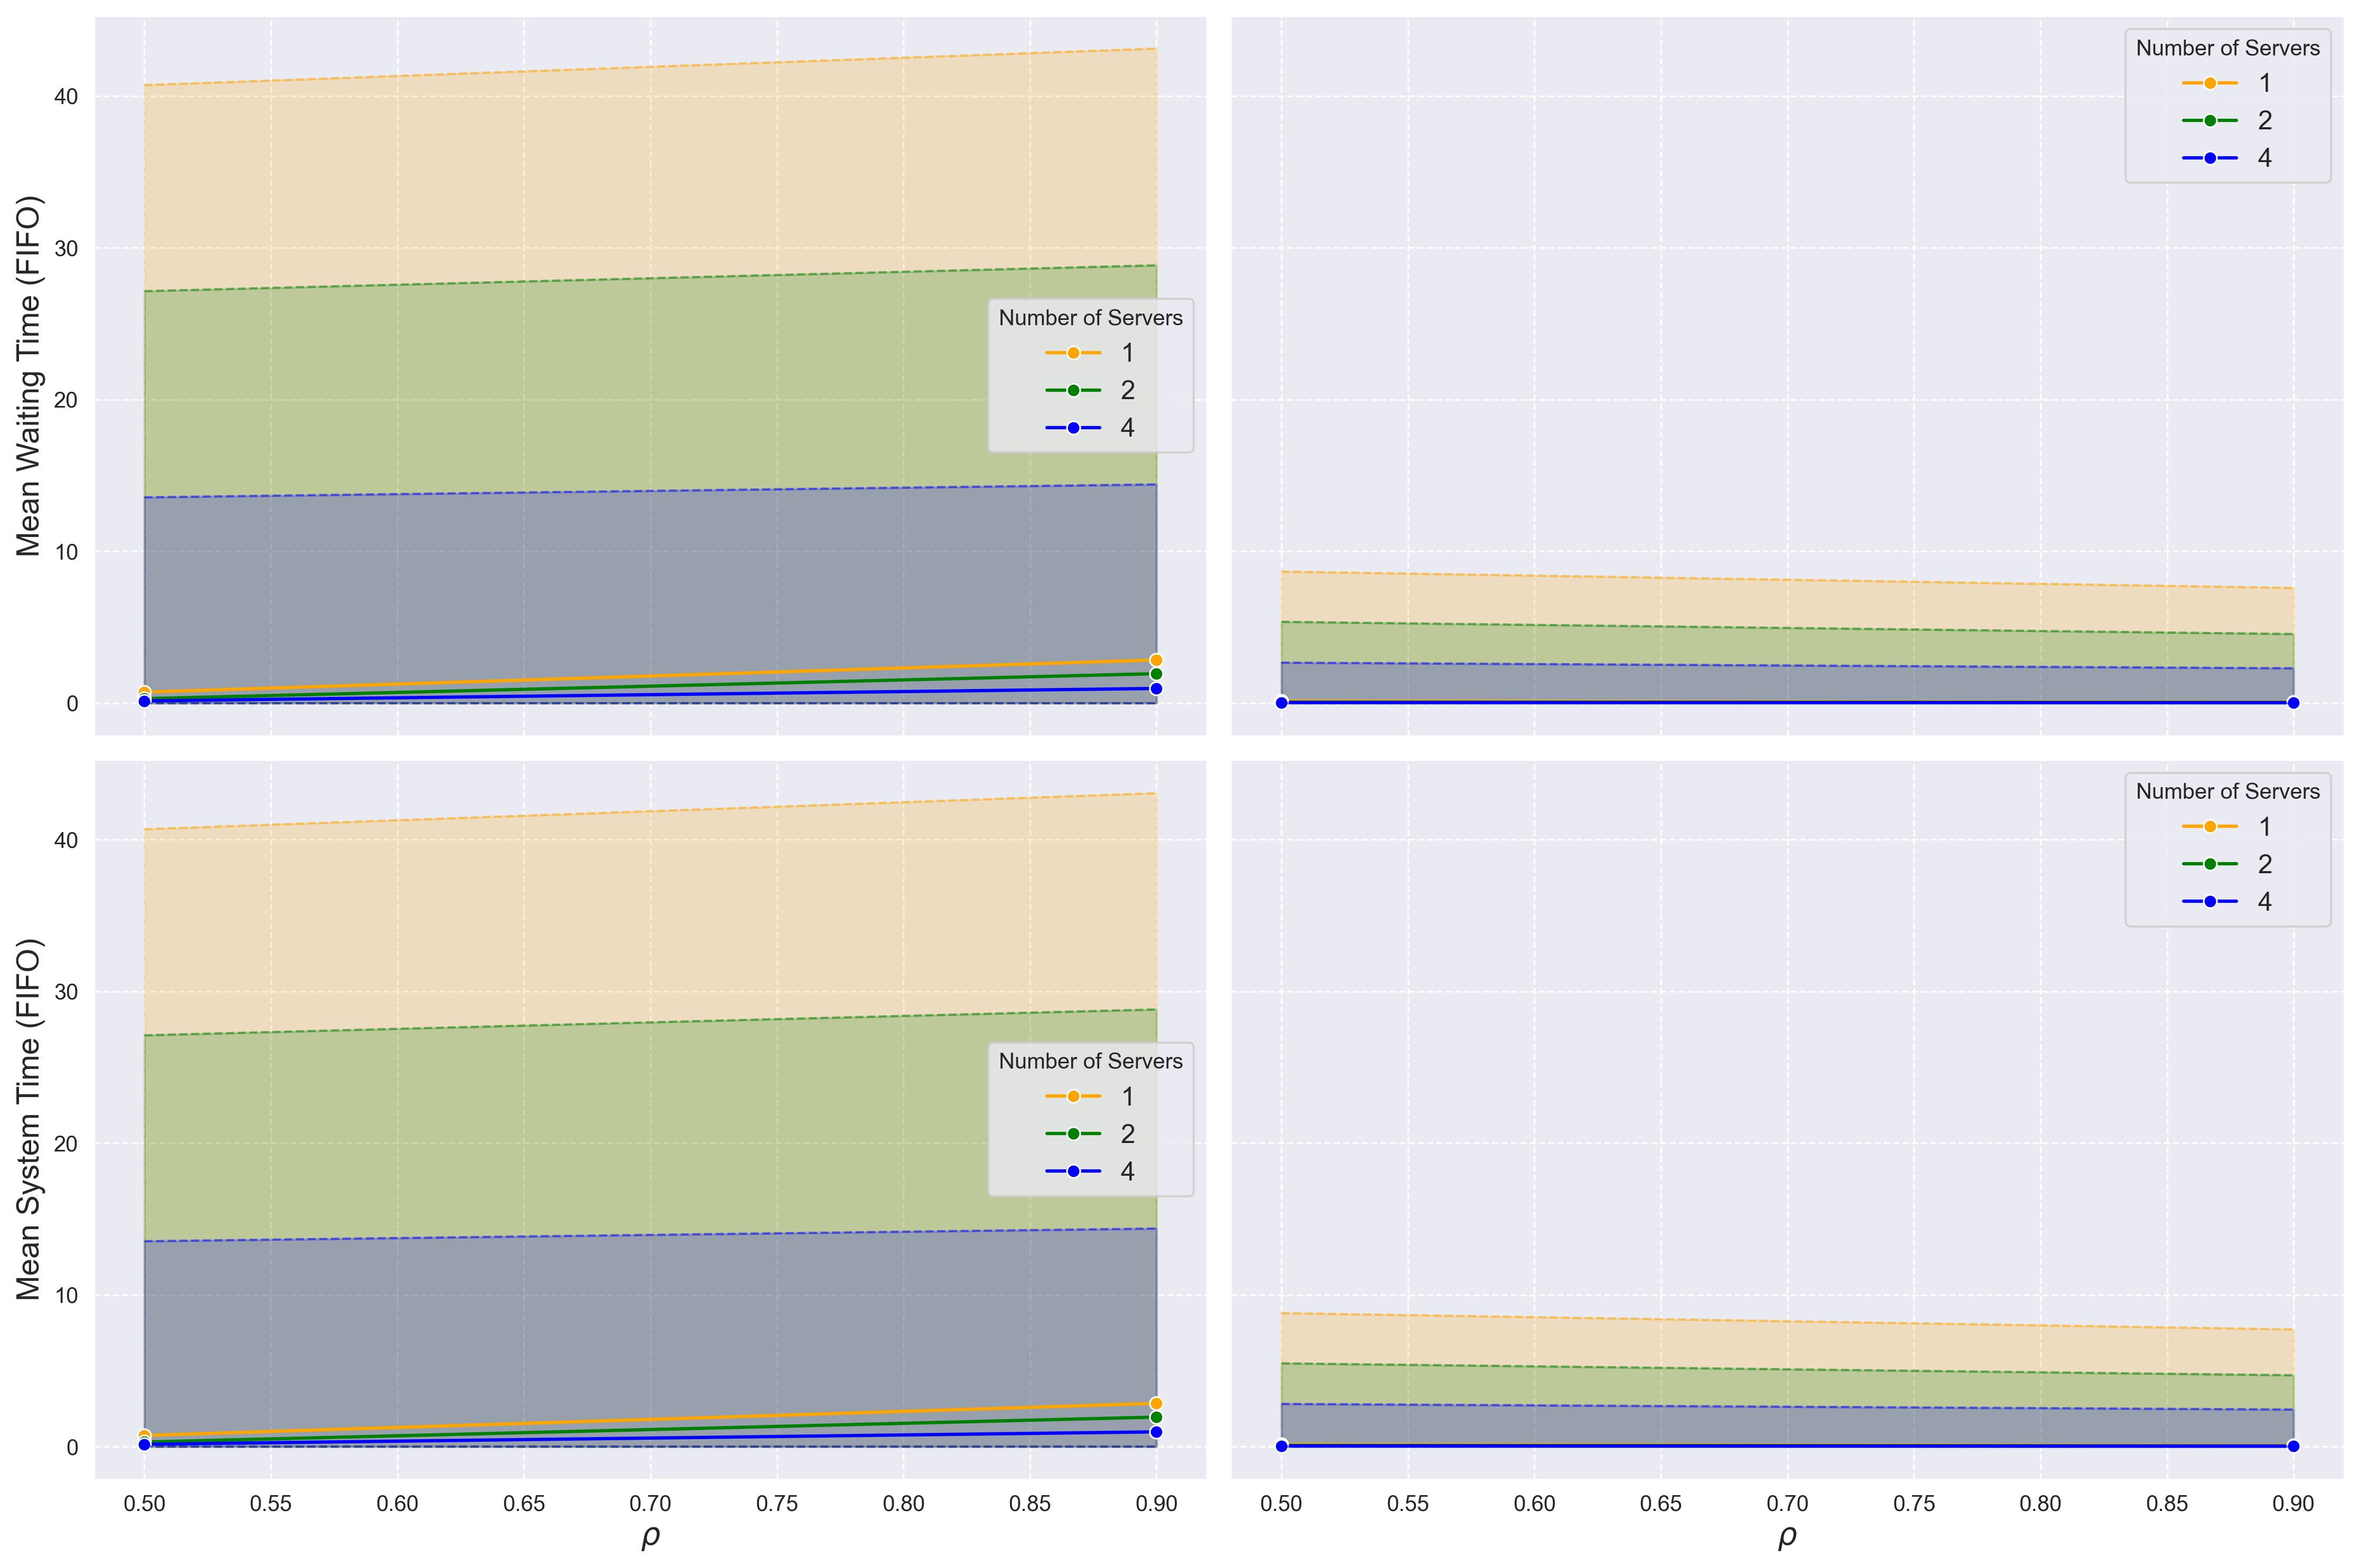

In [167]:
plot_rho_against_stat(results_hyperexp_FIFO, results_hyperexp_SJF, num_servers_arr, rhos, num_run_idx=-1)

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\1375568111.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


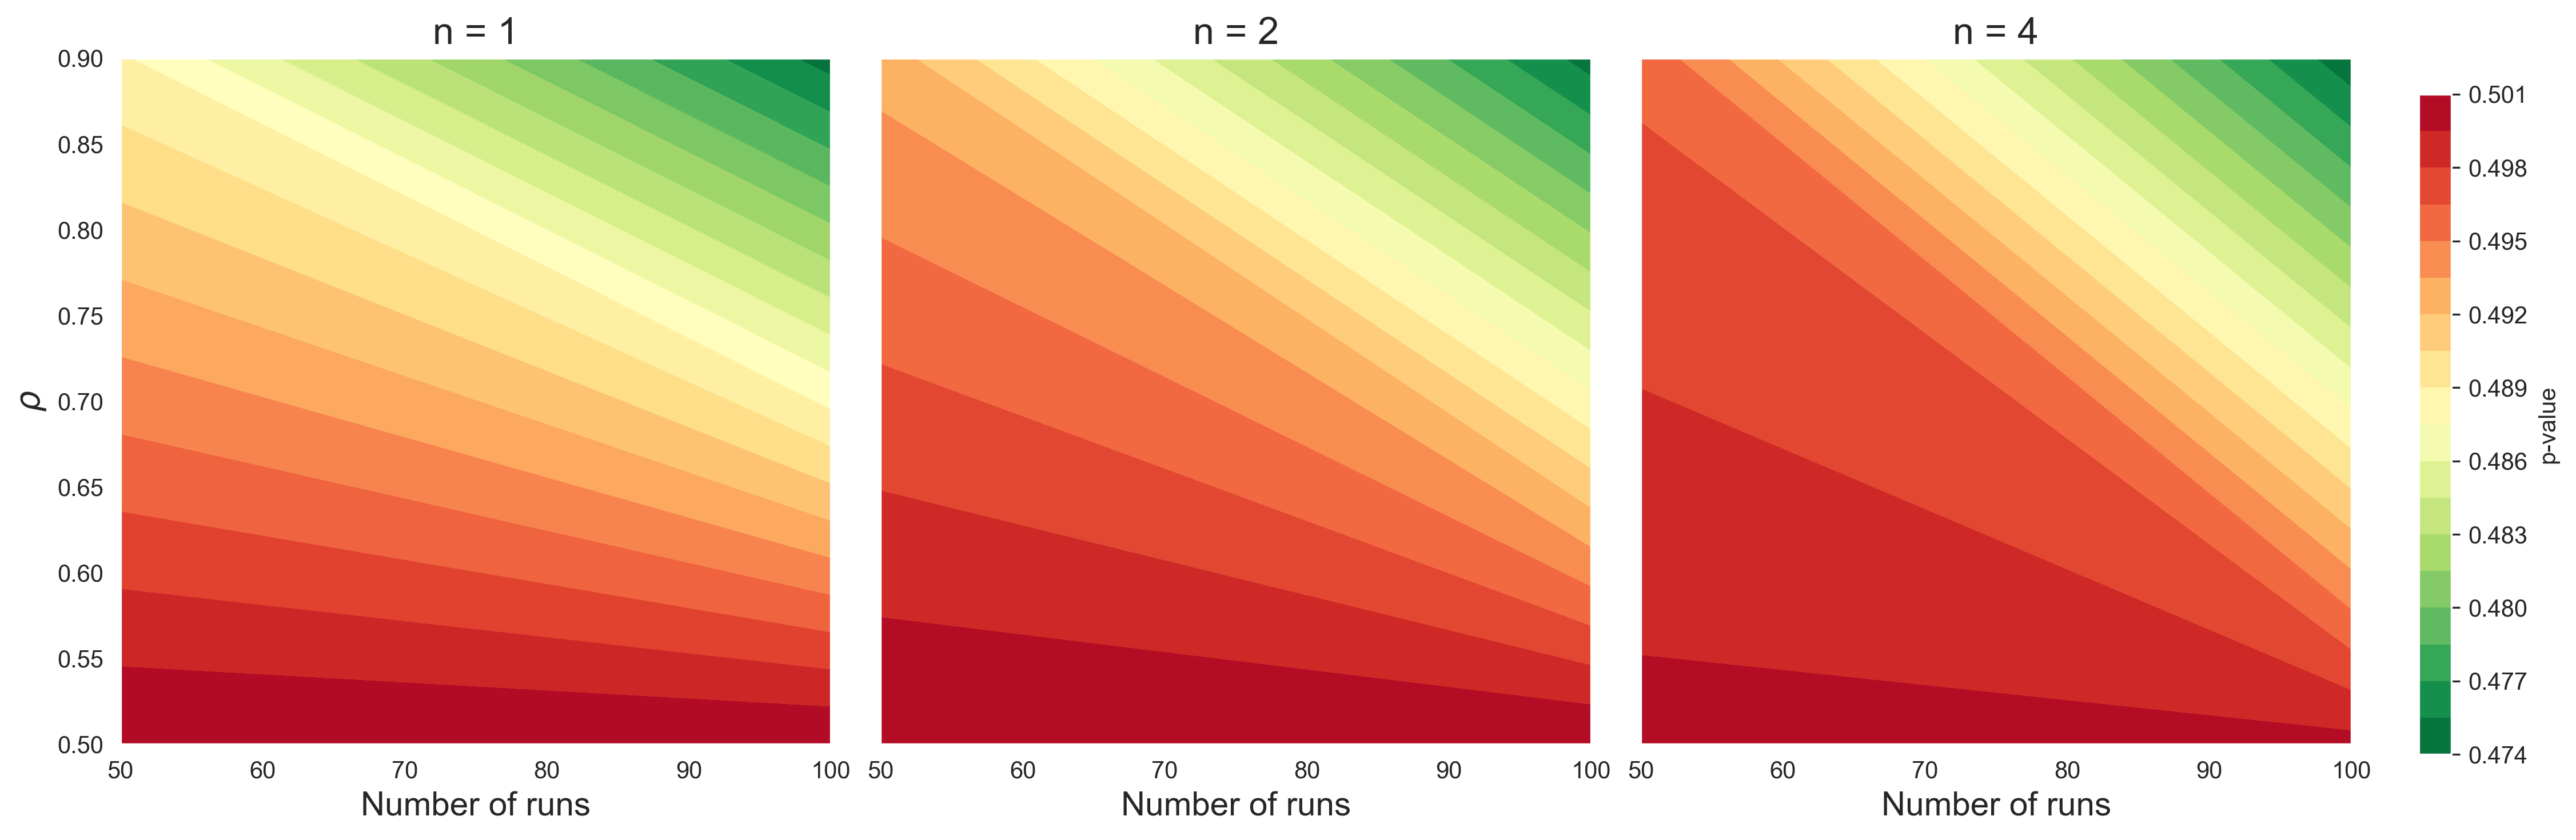

In [269]:
p_value_hyperexp_FIFO = Welch_test(results_hyperexp_FIFO, rhos, num_runs, variable='waiting_times')
plot_rho_numruns_against_pvalue(X, Y, p_value_hyperexp_FIFO, file_name=None)

C:\Users\lishu\AppData\Local\Temp\ipykernel_28424\1375568111.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


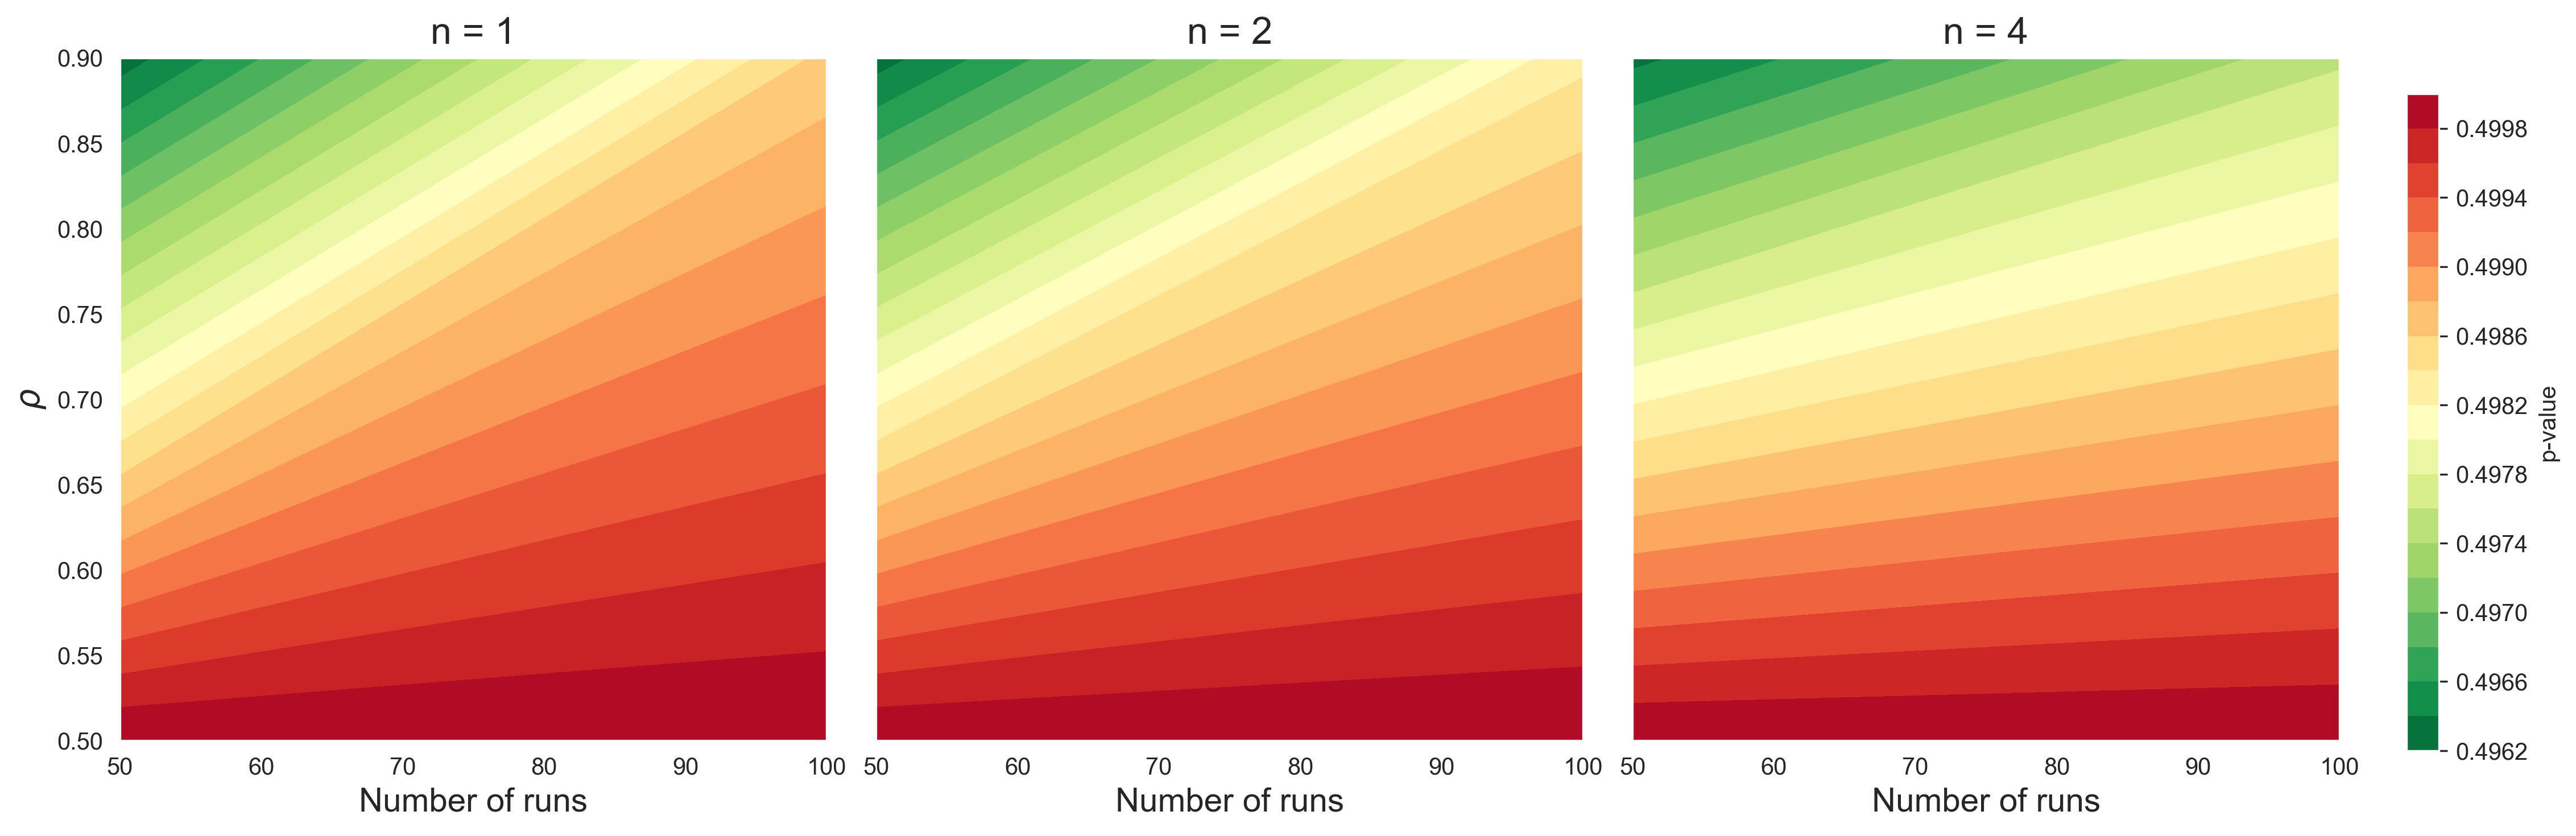

In [268]:
p_value_hyperexp_SJF = Welch_test(results_hyperexp_SJF, rhos, num_runs, variable='waiting_times')
plot_rho_numruns_against_pvalue(X, Y, p_value_hyperexp_SJF, file_name=None)